In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import PIL
import torchvision.transforms as transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

In [2]:
print(torch.backends.mps.is_built())

True


In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Set memory limit
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])  # Set the desired memory limit (in MB)
    except RuntimeError as e:
        print(e)


In [5]:
torch.set_default_device(0)

## Data loading and exploration

In [6]:
file = []
labels = []
resized_image = []
for dirname,_, filenames in os.walk('lung_colon_image_set'):
    for filename in filenames:
        if not filename.lower().endswith('.ds_store'):
            if "lung_aca" in dirname:
                labels.append("Lung Adenocarcinoma")
            elif "lung_n" in dirname:
                labels.append("Lung Benign Tissue")
            elif "lung_scc" in dirname:
                labels.append("Lung Squamous Cell Carcinoma")
            elif "colon_n" in dirname:
                labels.append("Colon Benign Tissue")
            elif "colon_aca" in dirname:
                labels.append("Colon Adenocarcinoma")
            file.append(os.path.join(dirname, filename))

In [7]:
Slabels = pd.Series(labels,name="Labels")
Sfile  = pd.Series(file,name="Filepaths")
data = pd.concat([Sfile,Slabels],axis=1)

In [8]:
data.head()

,Filepaths,Labels
0,lung_colon_image_set/lung_aca/lungaca2296.jpeg,Lung Adenocarcinoma
1,lung_colon_image_set/lung_aca/lungaca1843.jpeg,Lung Adenocarcinoma
2,lung_colon_image_set/lung_aca/lungaca294.jpeg,Lung Adenocarcinoma
3,lung_colon_image_set/lung_aca/lungaca3487.jpeg,Lung Adenocarcinoma
4,lung_colon_image_set/lung_aca/lungaca4342.jpeg,Lung Adenocarcinoma


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filepaths  25000 non-null  object
 1   Labels     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [8]:
data.isnull().sum()

Filepaths    0
Labels       0
dtype: int64

In [11]:
data['Labels'].value_counts()

Labels
Lung Adenocarcinoma             5000
Colon Benign Tissue             5000
Colon Adenocarcinoma            5000
Lung Benign Tissue              5000
Lung Squamous Cell Carcinoma    5000
Name: count, dtype: int64

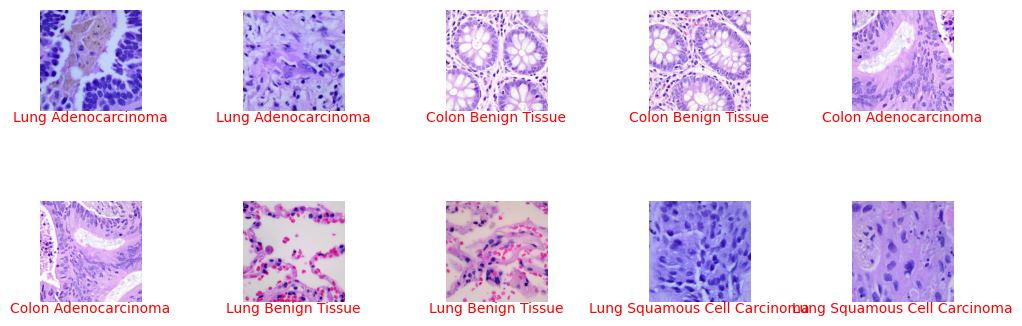

In [12]:
transform = transforms.Compose([transforms.ToTensor()])
grouped = data.groupby('Labels').head(2)
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the groups and plot the images in the subplots
for i, (_, row) in enumerate(grouped.iterrows()):
    # Extract the filepath and label from the row
    filepath = row['Filepaths']
    label = row['Labels']

    # Convert the filepath to a string
    filepath = str(filepath)

    # Open the image file
    image = plt.imread(filepath)

    # Plot the image in the corresponding subplot
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    annotation_x = 768 // 2
    annotation_y = 768 + 2
    # Annotate the image with its label
    ax.annotate(label, (annotation_x, annotation_y), color='red', ha='center', va='top')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Preprocessing

In [9]:
traindf,validationdf = train_test_split(data,random_state=25,train_size=0.8,stratify = data['Labels'])
validationdf,testdf = train_test_split(validationdf,random_state=25,train_size=0.5 ,stratify = validationdf['Labels'])

In [10]:
traindf["Labels"].value_counts()

Labels
Colon Benign Tissue             4000
Lung Squamous Cell Carcinoma    4000
Colon Adenocarcinoma            4000
Lung Benign Tissue              4000
Lung Adenocarcinoma             4000
Name: count, dtype: int64

In [16]:
validationdf['Labels'].value_counts()

Labels
2    500
4    500
1    500
0    500
3    500
Name: count, dtype: int64

In [17]:
testdf['Labels'].value_counts()

Labels
3    500
0    500
4    500
1    500
2    500
Name: count, dtype: int64

## DO NOT RUN....

In [16]:
def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path)
    resized_image = resize(image)
    normalized_image = normalize(np.array(resized_image))
    return normalized_image.flatten()

def resize(image):
    return image.resize((256,256))

def normalize(image):
    return image/255.0
    
# Preprocess the data

In [19]:
train_df = pd.DataFrame()
train_df['Images'] = [preprocess_image(image_path) for image_path in traindf["Filepaths"]]
train_df['Labels'] = traindf['Labels'].reset_index(drop=True)

In [20]:
train_df.head()

,Images,Labels
0,"[0.3176470588235294, 0.11372549019607843, 0.63...",1
1,"[0.29411764705882354, 0.20392156862745098, 0.7...",4
2,"[0.9215686274509803, 0.8235294117647058, 0.921...",1
3,"[0.9568627450980393, 0.8, 0.9215686274509803, ...",0
4,"[0.807843137254902, 0.8117647058823529, 0.9921...",4


In [21]:
test_df = pd.DataFrame()
test_df['Images'] = [preprocess_image(image_path) for image_path in testdf["Filepaths"]]
test_df['Labels'] = testdf['Labels'].reset_index(drop=True)

In [21]:
test_df.head()

,Images,Labels
0,"[0.8745098039215686, 0.7803921568627451, 0.780...",3
1,"[0.8862745098039215, 0.7686274509803922, 0.933...",0
2,"[0.6470588235294118, 0.30980392156862746, 0.76...",4
3,"[0.7647058823529411, 0.788235294117647, 0.8784...",4
4,"[0.8509803921568627, 0.788235294117647, 0.8235...",3


In [ ]:
validation_df = pd.DataFrame()
validation_df['Images'] = [preprocess_image(image_path) for image_path in validationdf["Filepaths"]]
validation_df['Labels'] = validationdf['Labels'].reset_index(drop=True)

In [ ]:
validation_df.head()

In [ ]:
np.prod(train_df['Images'][0].shape)# no of features

## TILL HERE....

In [11]:
from sklearn.tree import DecisionTreeClassifier


In [13]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset directory
dataset_dir = 'lung_colon_image_set'

# Set the batch size and image dimensions
batch_size = 32
image_size = (224, 224)  # Adjust this according to your image size

# Create the ImageDataGenerator objects
datagen = ImageDataGenerator(rescale=1.0 / 255)


In [108]:
train_generator = datagen.flow_from_dataframe(
    traindf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='grayscale',  # Set color_mode to 'grayscale'
# Adjust as needed
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

validation_generator = datagen.flow_from_dataframe(
    validationdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='grayscale',  # Set color_mode to 'grayscale'
# Adjust as needed
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

test_generator = datagen.flow_from_dataframe(
    testdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='grayscale',  # Set color_mode to 'grayscale'
# Adjust as needed
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)


Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [109]:
X = validation_generator.next()[0]  # Get the image data (features)
y =validation_generator.classes  # Get the corresponding labels

# Reshape the image data to a 2D array
num_samples = X.shape[0]
X = X.reshape(num_samples, -1)  # Reshape to (num_samples, flattened_image_size)
print(len(X[0]))

50176


In [111]:
X = train_generator.next()[0]  # Get the image data (features)
y = train_generator.classes  # Get the corresponding labels

# Reshape the image data to a 2D array
num_samples = X.shape[0]
X = X.reshape(num_samples, -1)  # Reshape to (num_samples, flattened_image_size)
print(len(X))

10


In [123]:
def preprocess(train_generator):
    num_samples = len(train_generator.filenames)

    # Initialize empty arrays to store the features and labels
    X = []
    y = train_generator.classes  # Get the corresponding labels


    # Iterate over all the batches and collect the features and labels
    for _ in range(num_samples // batch_size):
        batch_X = train_generator.next()[0]
        X.extend(batch_X)

    # Convert the collected data to a numpy array
    #X = np.array(X)

    print(len(y))
    # Concatenate the features and labels from all the batches
    X = np.concatenate(X, axis=0)
    X = np.array(X)
    # Reshape the image data to a 2D array
    X = X.reshape(num_samples, -1)  # Reshape to (num_samples, flattened_image_size)
    print(len(X),len(y))
    return X,y

In [135]:
def get_data_from_generator(generator):
    num_samples = generator.samples

    # Initialize empty arrays to store the features and labels
    X = []
    y = []

    # Iterate over all the batches and collect the features and labels
    for _ in range(num_samples // generator.batch_size):
        batch_X, batch_y = generator.next()
        X.extend(batch_X)
        y.extend(batch_y)

    # Convert the collected data to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Reshape the image data if needed
    if len(X.shape) > 2:
        X = X.reshape(-1, *X.shape[1:])

    return X.reshape(X.shape[0], -1), y


In [136]:
print("TRAIN:")
trainX,trainY = get_data_from_generator(train_generator)
print(len(trainX),len(trainY))

print("VALIDATION:")
validationX,validationY = get_data_from_generator(validation_generator)
print(len(validationX),len(validationY))

print("TEST:")
testX,testY = get_data_from_generator(test_generator)
print(len(testX),len(testY))


TRAIN:
20000 20000
VALIDATION:
2500 2500
TEST:
2500 2500


In [90]:
validationX[0]

0.7372549

In [17]:
tree_classifier = DecisionTreeClassifier()

# Train the decision tree classifier using the extracted features
tree_classifier.fit(X, y)

DecisionTreeClassifier()

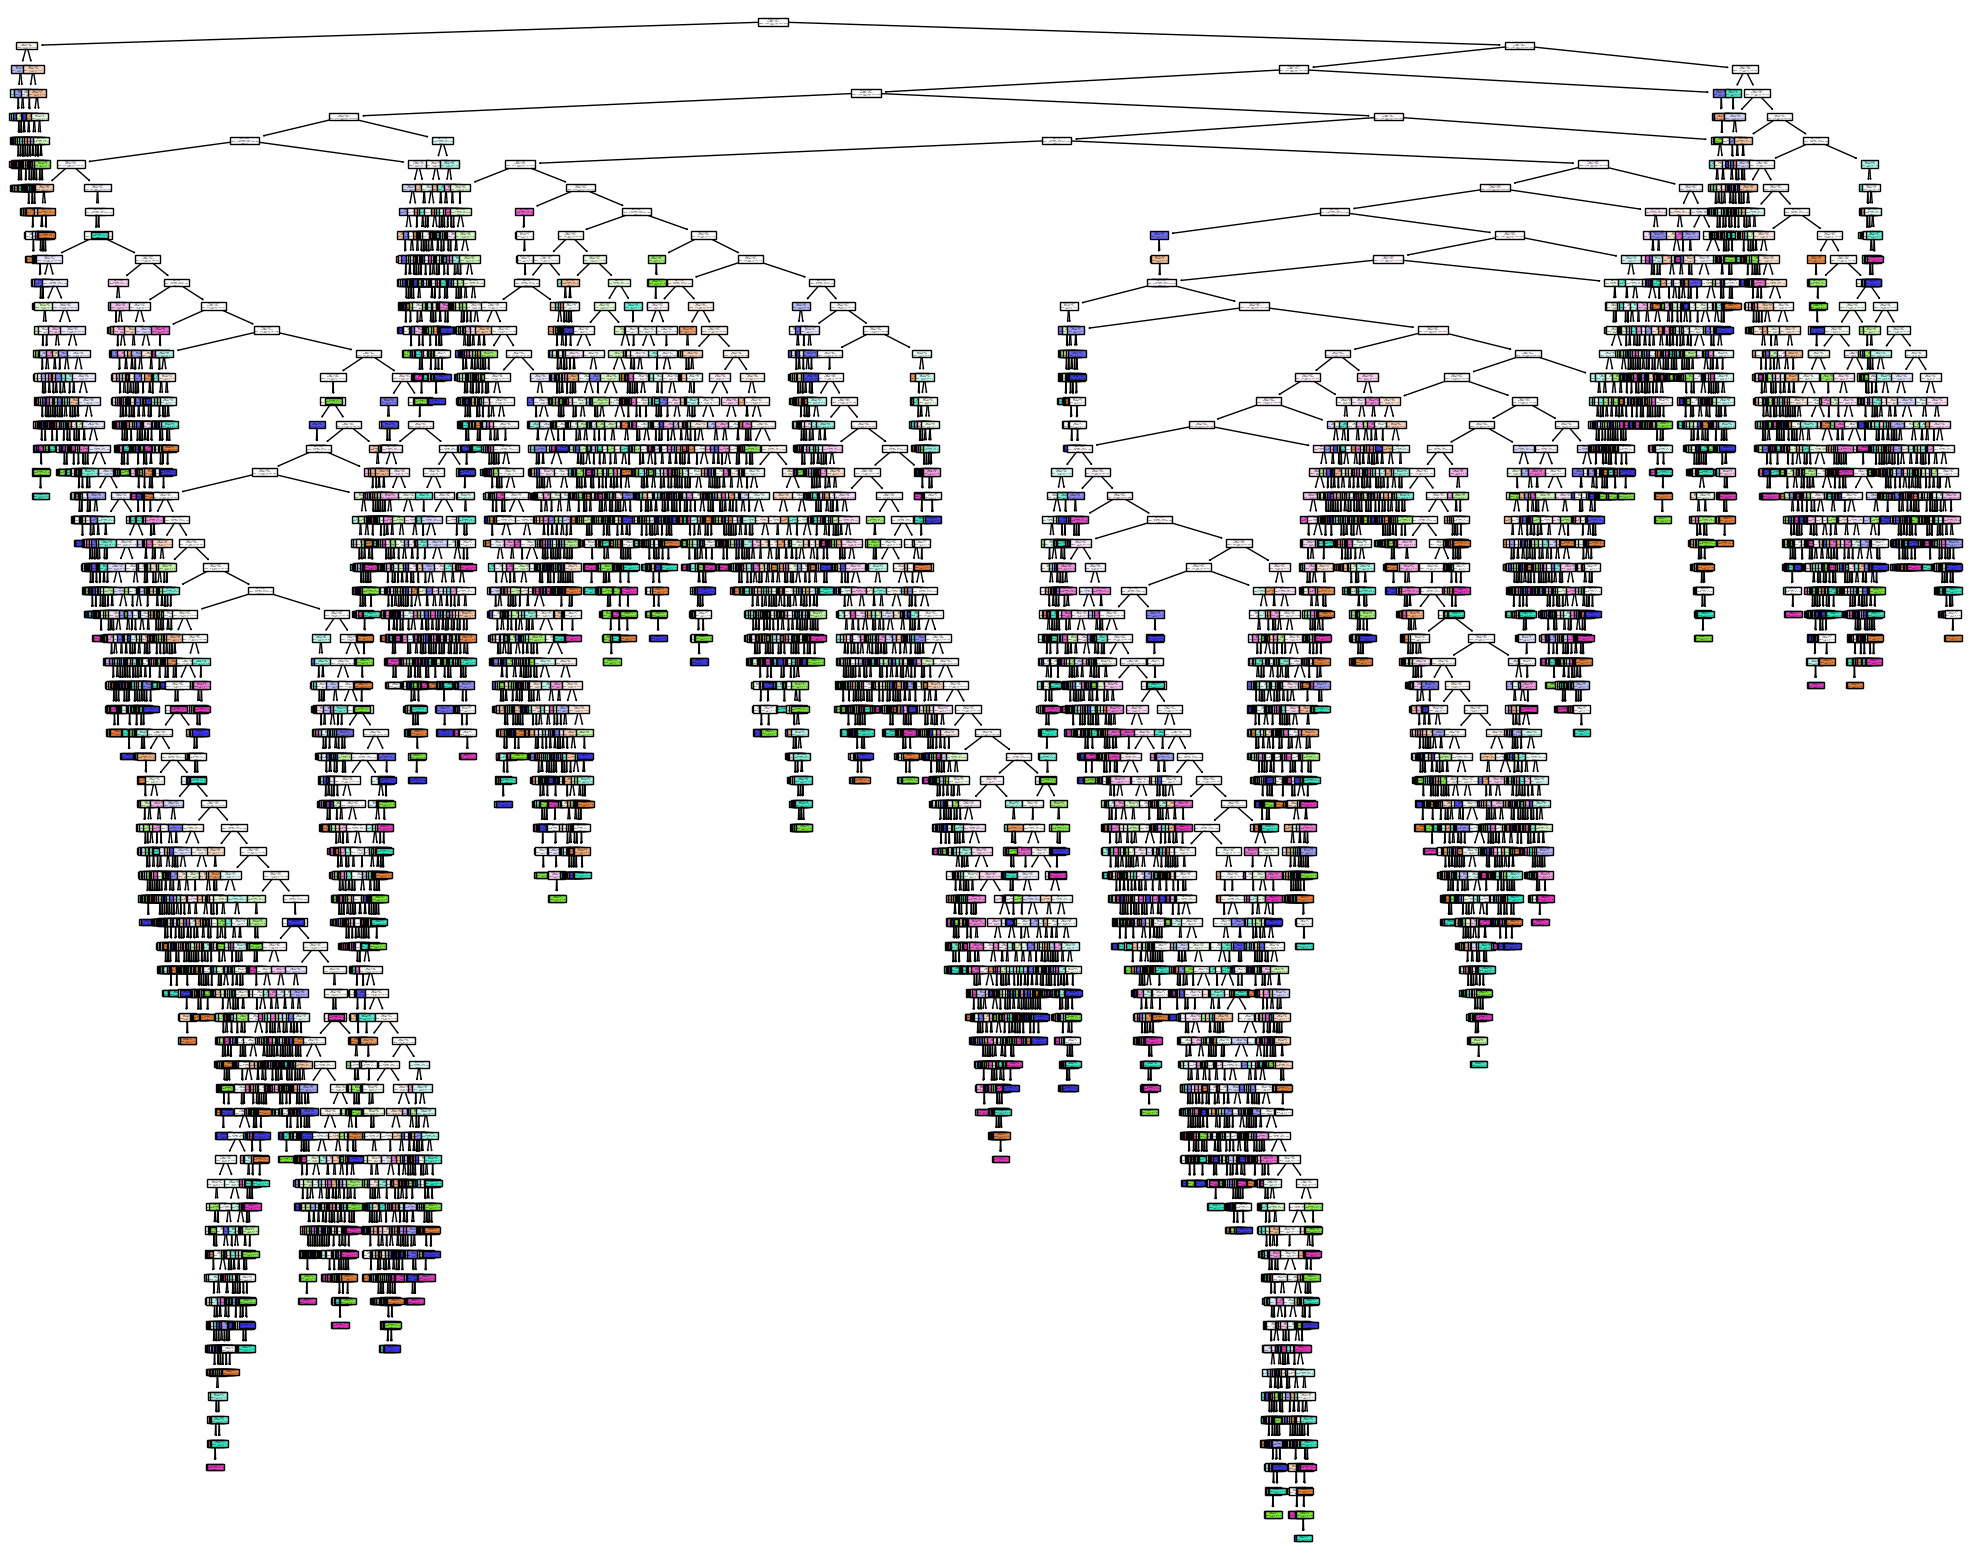

In [20]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
feature_names = [str(i) for i in range(X.shape[1])] 
class_names = [str(label) for label in train_generator.classes]  # Convert class labels to strings
_ = tree.plot_tree(tree_classifier,
                   feature_names=feature_names,
                   class_names=class_names,
                   filled=True)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from random import randint
from sklearn.model_selection import RandomizedSearchCV

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Define the hyperparameters and their possible values for tuning
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,10,15],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,3,5],
}

# Perform randomized search using cross-validation
random_search = RandomizedSearchCV(clf, param_dist, n_iter=10, cv=5,n_jobs=4)
random_search.fit(trainX, trainY)

# Get the best hyperparameters and corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print(best_params)
# Evaluate the best model on the test set

In [ ]:
y_val_pred = best_model.predict(validationX)
val_accuracy = accuracy_score(validationY, y_val_pred)

# Evaluate the model on the test set
y_test_pred = best_model.predict(testX)
test_accuracy = accuracy_score(testY, y_test_pred)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)